In [1]:
# This notebook is used for testing linear units and weight normalization
# in the draculab module

# This file is supposed to be in .../draculab/tests/ , so cd before importing:
%cd ..

from draculab import *
import re  # regular expressions module, for the loadData function
import matplotlib.pyplot as plt   # more plotting tools
import numpy as np
import time

/home/z/projects/draculab


In [2]:
def loadData(filename):
    # Receives the name of a datafile saved in XPP's .dat format, 
    # and returns numpy arrays with the data from the columns
    # The format is simply putting in each line the values of time and state variables
    # separated by spaces. Time is the first column.
    
    # Counting the lines and columns in order to allocate the numpy arrays
    nlines = sum(1 for line in open(filename,'r'))
    n_columns = len(re.split(' .', open(filename,'r').readline()))
    # XPP puts an extra space at the end of the line, so I used ' .' instead of ' '
    
    # We'll store everything in one tuple of numpy arrays, one per column
    values = tuple(np.zeros(nlines) for i in range(n_columns))
    for idx, line in enumerate(open(filename,'r')):
        listed = re.split(' ', re.split(' $', line)[0]) # the first split removes the trailing space
        for jdx, value in enumerate(listed):  
            values[jdx][idx] = float(value) 
            
    return values
    
def conn_mat(net):
    # Get the connection matrix of a network in a Numpy array
    conns = np.zeros((net.n_units,net.n_units))
    for syn_list in net.syns:
        for syn in syn_list:
            conns[syn.postID,syn.preID] = syn.w
    return conns

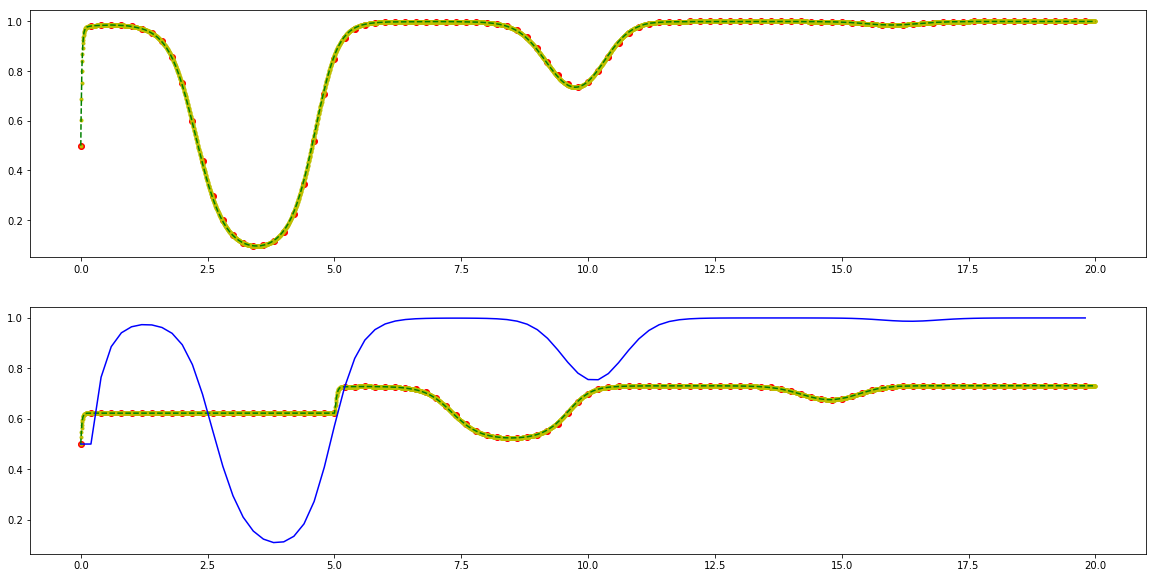

In [3]:

################# TEST 1 ####################
######### 1) Create a network
net_params = {'min_delay' : 0.2, 'min_buff_size' : 8 } # parameter dictionary for the network
n1 = network(net_params)

######### 2) Put some units in the network
# default parameters for the units
pars = { 'coordinates' : np.zeros(3),
         'delay' : 1., 'init_val' : 0.5, 'tau_fast' : 1.,
         'slope' : 1., 'thresh' : 0.0, 'tau' : 0.02,
         'type' : unit_types.source, 'function' : lambda x : None } 
inputs = n1.create(2,pars) # creating two input sources
# setting the input functions
n1.units[inputs[0]].set_function(lambda t: 0.5*t)
n1.units[inputs[1]].set_function(lambda t: -4.*np.sin(t))
pars['type'] = unit_types.sigmoidal
sig_units = n1.create(2,pars) # creating two sigmoidal units

######### 3) Connect the units in the network
conn_spec = {'rule' : 'all_to_all', 'delay' : 1.,
              'allow_autapses' : False } # connection specification dictionary
syn_pars = {'init_w' : 1., 'lrate' : 0.0, 
            'type' : synapse_types.oja} # synapse parameters dictionary
n1.connect([inputs[0]], [sig_units[0]], conn_spec, syn_pars)
conn_spec['delay'] = 2.
n1.connect([inputs[1]], [sig_units[0]], conn_spec, syn_pars)
conn_spec['delay'] = 5.
n1.connect([sig_units[0]], [sig_units[1]], conn_spec, syn_pars)
conn_spec['delay'] = 6.
n1.connect([sig_units[1]], [sig_units[0]], conn_spec, syn_pars)
######-----#####
pars['type'] = unit_types.source
track = n1.create(1, pars)
n1.units[track[0]].set_function(lambda x: n1.units[sig_units[0]].lpf_fast)
#####------######
# running and visualizing 
sim_dat = n1.run(20.)
xpp_dat = loadData('./tests/sim1oderun.dat')
matlab_dat = loadData('./tests/sim1matrun.txt')

fig = plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(sim_dat[0], sim_dat[1][2], 'ro', xpp_dat[0], xpp_dat[1], 'y.', figure=fig)
plt.plot(matlab_dat[0], matlab_dat[1], 'g--', figure=fig)
plt.subplot(212)
plt.plot(sim_dat[0], sim_dat[1][3], 'ro', xpp_dat[0], xpp_dat[2], 'y.', figure=fig)
plt.plot(matlab_dat[0], matlab_dat[2], 'g--', figure=fig)

plt.plot(sim_dat[0], sim_dat[1][track[0]], 'b')

#fig2 = plt.figure(figsize=(20,5))
#plt.plot(sim_dat[0], sim_dat[1][0], sim_dat[0], sim_dat[1][1], 'y.', figure=fig2)

plt.show()


In [4]:
n1.units[sig_units[0]].steps

26

Execution time: 0.11445760726928711 seconds


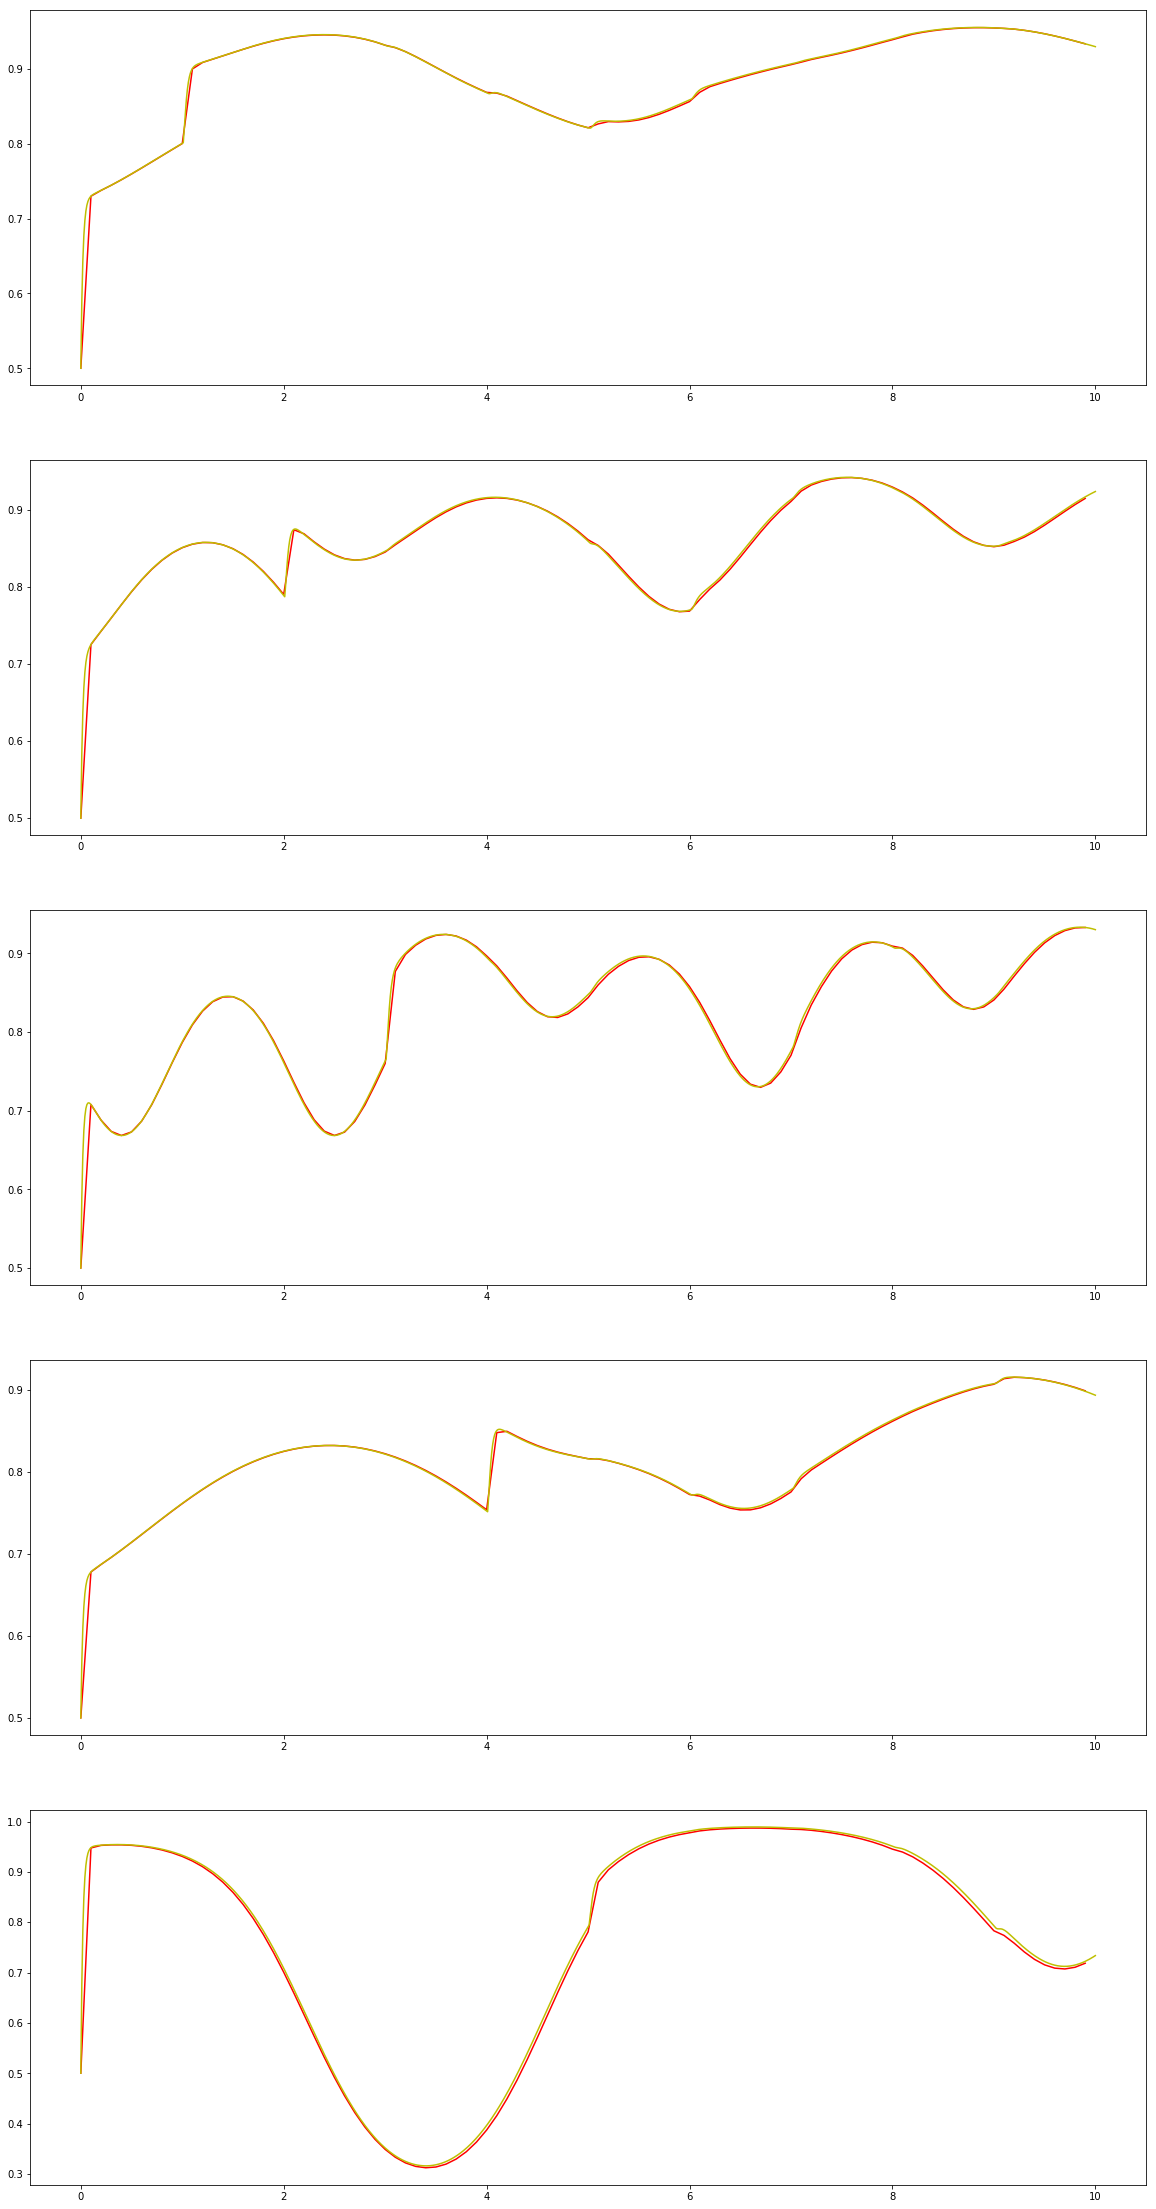

In [5]:
################# TEST 2 #################### 
#### Compares with the output produced by sim3.ode . When running, set nUmerics -> Dt to 0.01 .
######### 1) Create a network
net_params = {'min_delay' : 0.1, 'min_buff_size' : 5, 'rtol' : 1e-4, 'atol' : 1e-4 } # parameter dictionary for the network
n2 = network(net_params)

######### 2) Put some units in the network
# default parameters for the units
pars = { 'init_val' : 0.5, 'tau_fast' : 1.,
         'slope' : 1., 'thresh' : 0.0, 'tau' : 0.02,
         'type' : unit_types.source, 'function' : lambda x : None } 
inputs = n2.create(5,pars) # creating five input sources
# setting the input functions
n2.units[inputs[0]].set_function(lambda t: 0.5*np.sin(t))
n2.units[inputs[1]].set_function(lambda t: -0.5*np.sin(2*t))
n2.units[inputs[2]].set_function(lambda t: 0.5*np.sin(3*t))
n2.units[inputs[3]].set_function(lambda t: -0.5*np.sin(t))
n2.units[inputs[4]].set_function(lambda t: 2.0*np.sin(t))
pars['type'] = unit_types.sigmoidal
sig_units = n2.create(5,pars) # creating sigmoidal units


######### 3) Connect the units in the network
conn_spec = {'rule' : 'all_to_all', 'delay' : 1.,
             'allow_autapses' : False} # connection specification dictionary
syn_pars = {'init_w' : 1., 'lrate' : 0.5, 
            'type' : synapse_types.static} # synapse parameters dictionary

# In the XPP code, projections to unit X have a delay X
# and synapses from unit X have a weight 2*0.X,
for idx_to, unit_to in enumerate(sig_units):
    conn_spec['delay'] = float(idx_to+1)
    n2.connect([inputs[idx_to]], [unit_to], conn_spec, syn_pars)
    if idx_to == 4: # the last unit has oja synapses in connections from sigmoidals
        syn_pars['type'] = synapse_types.oja
    for idx_from, unit_from in enumerate(sig_units):
        if unit_from != unit_to:
            syn_pars['init_w'] = 0.2*(idx_from+1)
            n2.connect([unit_from], [unit_to], conn_spec, syn_pars)

######### 4) Running and visualizing 
start_time = time.time()
sim_dat = n2.run(10.)
print('Execution time: %s seconds' % (time.time() - start_time))
xpp_dat = loadData('./tests/sim3oderun0.dat')  # ran in XPP with lrate = 0
xpp_dat = loadData('./tests/sim3oderun5.dat')  # ran in XPP with lrate = 0.5

fig = plt.figure(figsize=(20,40))
plt.subplot(511)
plt.plot(sim_dat[0], sim_dat[1][5], 'r', xpp_dat[0], xpp_dat[1], 'y', figure=fig)
plt.subplot(512)
plt.plot(sim_dat[0], sim_dat[1][6], 'r', xpp_dat[0], xpp_dat[2], 'y', figure=fig)
plt.subplot(513)
plt.plot(sim_dat[0], sim_dat[1][7], 'r', xpp_dat[0], xpp_dat[3], 'y', figure=fig)
plt.subplot(514)
plt.plot(sim_dat[0], sim_dat[1][8], 'r', xpp_dat[0], xpp_dat[4], 'y', figure=fig)
plt.subplot(515)
plt.plot(sim_dat[0], sim_dat[1][9], 'r', xpp_dat[0], xpp_dat[5], 'y', figure=fig)

plt.show()
# 1.786 -- initially
# 0.1056 -- typical

Execution time: 0.10470032691955566 seconds


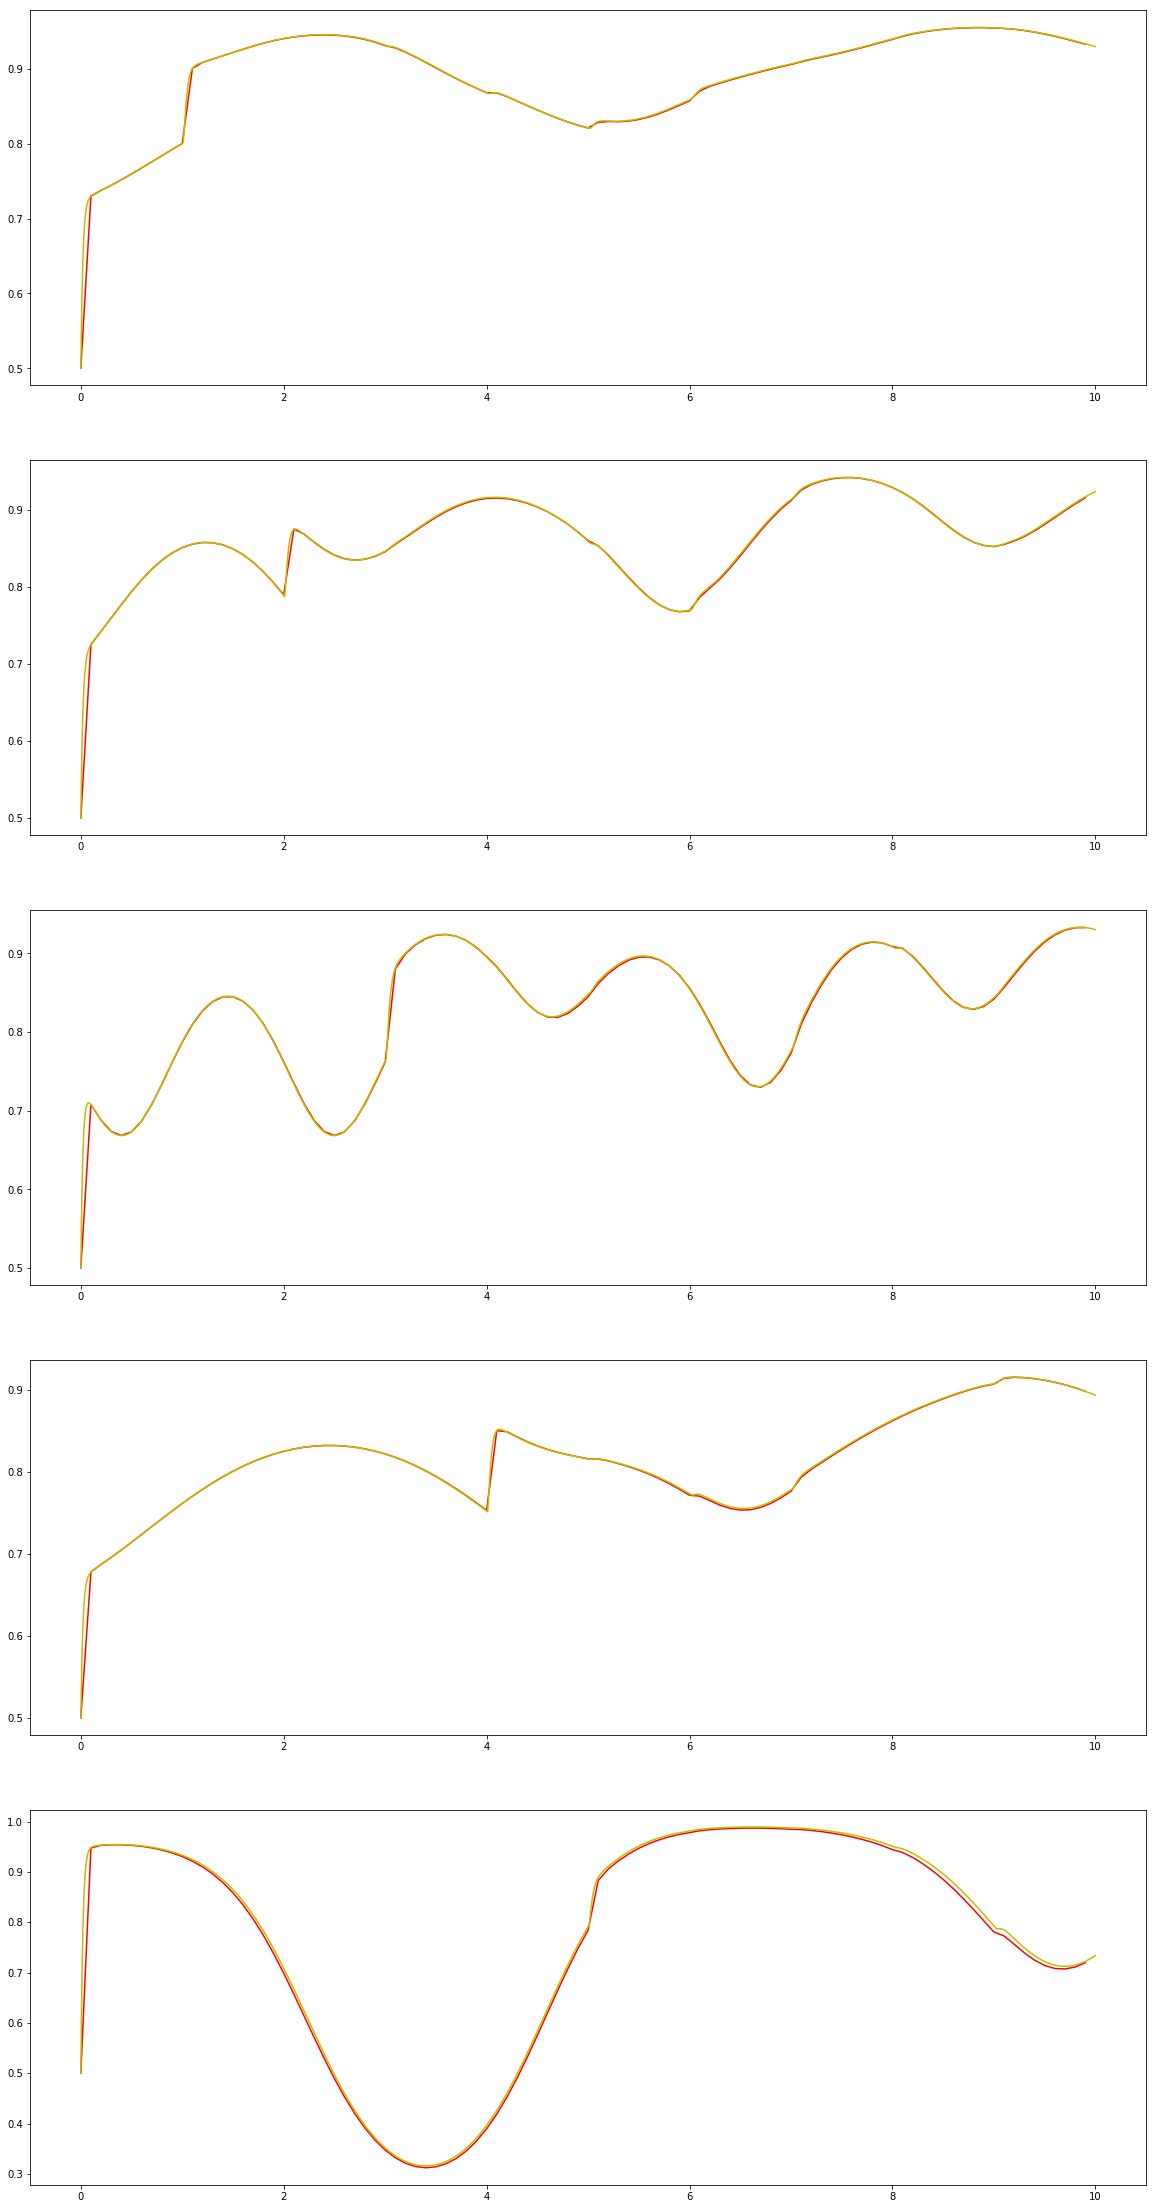

In [6]:
################# TEST 2a ####################
# Same as test 2, but use custom_fi units instead of sigmoidal units.
######### 1) Create a network
net_params = {'min_delay' : 0.1, 'min_buff_size' : 10, 'rtol' : 1e-4, 'atol' : 1e-4 } # parameter dictionary for the network
n2 = network(net_params)

######### 2) Put some units in the network
# creating the input functions
funcs = [ lambda t: 0.5*np.sin(t), lambda t: -0.5*np.sin(2*t), lambda t: 0.5*np.sin(3*t),
          lambda t: -0.5*np.sin(t), lambda t: 2.0*np.sin(t)]
# default parameters for the units
pars = { 'init_val' : 0.5, 'tau_fast' : 1., 'type' : unit_types.source, 'function' : funcs } 
inputs = n2.create(5,pars) # creating five input sources
# setting the sigmoidal function
sig_f = lambda x: 1. / (1. + np.exp( -1.*(x - 0.0) ))
pars['type'] = unit_types.custom_fi
pars['tau'] = 0.02
pars['function'] = sig_f
sig_units = n2.create(5,pars) # creating sigmoidal units

######### 3) Connect the units in the network
conn_spec = {'rule' : 'all_to_all', 'delay' : 1.,
             'allow_autapses' : False} # connection specification dictionary
syn_pars = {'init_w' : 1., 'lrate' : 0.5, 
            'type' : synapse_types.static} # synapse parameters dictionary

# In the XPP code, projections to unit X have a delay X
# and synapses from unit X have a weight 2*0.X,
for idx_to, unit_to in enumerate(sig_units):
    conn_spec['delay'] = float(idx_to+1)
    n2.connect([inputs[idx_to]], [unit_to], conn_spec, syn_pars)
    if idx_to == 4: # the last unit has oja synapses in connections from sigmoidals
        syn_pars['type'] = synapse_types.oja
    for idx_from, unit_from in enumerate(sig_units):
        if unit_from != unit_to:
            syn_pars['init_w'] = 0.2*(idx_from+1)
            n2.connect([unit_from], [unit_to], conn_spec, syn_pars)

######### 4) Running and visualizing 
start_time = time.time()
sim_dat = n2.run(10.)
print('Execution time: %s seconds' % (time.time() - start_time))
xpp_dat = loadData('./tests/sim3oderun0.dat')  # ran in XPP with lrate = 0
xpp_dat = loadData('./tests/sim3oderun5.dat')  # ran in XPP with lrate = 0.5

fig = plt.figure(figsize=(20,40))
plt.subplot(511)
plt.plot(sim_dat[0], sim_dat[1][5], 'r', xpp_dat[0], xpp_dat[1], 'y', figure=fig)
plt.subplot(512)
plt.plot(sim_dat[0], sim_dat[1][6], 'r', xpp_dat[0], xpp_dat[2], 'y', figure=fig)
plt.subplot(513)
plt.plot(sim_dat[0], sim_dat[1][7], 'r', xpp_dat[0], xpp_dat[3], 'y', figure=fig)
plt.subplot(514)
plt.plot(sim_dat[0], sim_dat[1][8], 'r', xpp_dat[0], xpp_dat[4], 'y', figure=fig)
plt.subplot(515)
plt.plot(sim_dat[0], sim_dat[1][9], 'r', xpp_dat[0], xpp_dat[5], 'y', figure=fig)

plt.show()
#1.9436 -- initially
# 0.093 -- typical

Execution time: 0.026049375534057617 seconds


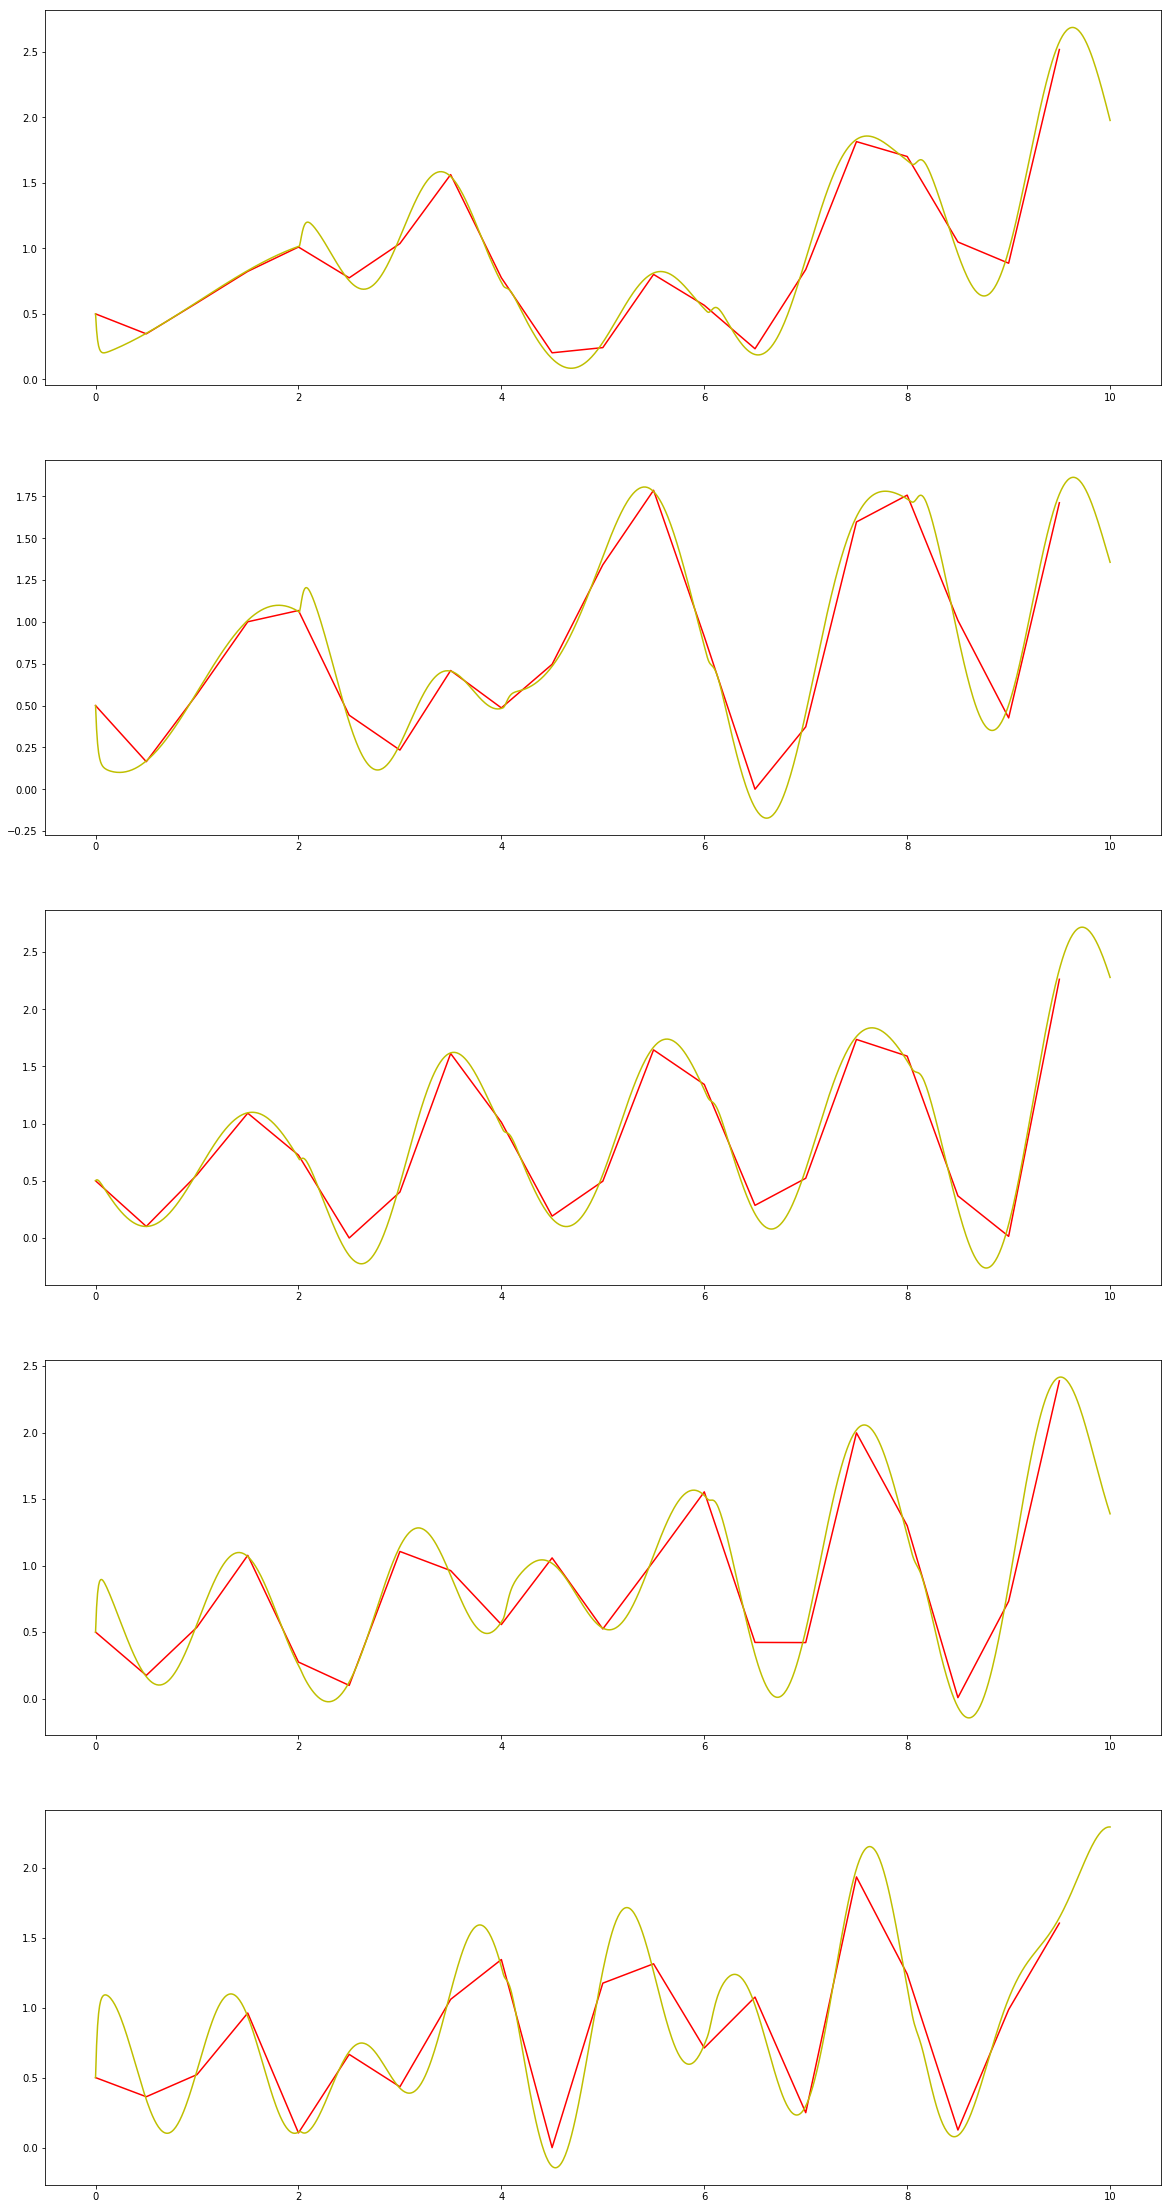

In [7]:

################# TEST 3 ####################
## A simplified version of TEST 2 ##
#### Compares with the output produced by sim3b.ode

######### 1) Create a network
net_params = {'min_delay' : .5, 'min_buff_size' : 40 } # parameter dictionary for the network
n3 = network(net_params)

######### 2) Put some units in the network
# default parameters for the units
pars = { 'coordinates' : [np.array([0.,1.])]*5, 'lambda': 1., 'mu':0., 'sigma':0.,
         'delay' : 2., 'init_val' : 0.5,
         'slope' : 1., 'thresh' : 0.0, 'tau' : 0.02,
         'type' : unit_types.source, 'function' : lambda x: None} 
inputs = n3.create(5,pars) # creating five input sources
# setting the input functions
n3.units[inputs[0]].set_function(lambda t: np.sin(t))
n3.units[inputs[1]].set_function(lambda t: np.sin(2*t))
n3.units[inputs[2]].set_function(lambda t: np.sin(3*t))
n3.units[inputs[3]].set_function(lambda t: np.sin(4*t))
n3.units[inputs[4]].set_function(lambda t: np.sin(5*t))
pars['type'] = unit_types.noisy_linear
sig_units = n3.create(5,pars) # creating units

######### 3) Connect the units in the network
conn_spec = {'rule' : 'all_to_all', 'delay' : {'distribution' : 'uniform', 'low' : 1., 'high' : 1.},
             'allow_autapses' : False } # connection specification dictionary
syn_pars = {'init_w' : 0.5, 'lrate' : 0.0, 
            'type' : synapse_types.static} # synapse parameters dictionary

# In the XPP code, projections from inputs have delay 1 and weight 1,
# whereas projections from sigmoidals have delay 2 and weight 0.3
for inp_unit, sig_unit in zip(inputs,sig_units):
    n3.connect([inp_unit], [sig_unit], conn_spec, syn_pars)
    
conn_spec['delay'] = 2.
syn_pars['init_w'] = 0.3
n3.connect(sig_units, sig_units, conn_spec, syn_pars)
    
######### 4) Running and visualizing 
start_time = time.time()
sim_dat = n3.run(10)
print('Execution time: %s seconds' % (time.time() - start_time))
xpp_dat = loadData('./tests/sim4aoderun.dat')

fig = plt.figure(figsize=(20,40))
plt.subplot(511)
plt.plot(sim_dat[0], sim_dat[1][5], 'r', xpp_dat[0], xpp_dat[1], 'y', figure=fig)
plt.subplot(512)
plt.plot(sim_dat[0], sim_dat[1][6], 'r', xpp_dat[0], xpp_dat[2], 'y', figure=fig)
plt.subplot(513)
plt.plot(sim_dat[0], sim_dat[1][7], 'r', xpp_dat[0], xpp_dat[3], 'y', figure=fig)
plt.subplot(514)
plt.plot(sim_dat[0], sim_dat[1][8], 'r', xpp_dat[0], xpp_dat[4], 'y', figure=fig)
plt.subplot(515)
plt.plot(sim_dat[0], sim_dat[1][9], 'r', xpp_dat[0], xpp_dat[5], 'y', figure=fig)

plt.show()

#np.set_printoptions(precision=3)
#print(conn_mat(n3))

# 0.1906 with min_delay = .5, min_buff_size = 40